# Initialization

In [1]:
# code developed in Python 3.12
!python --version

Python 3.12.9


In [2]:
# install modules
!pip install -r requirements.txt --disable-pip-version-check | tail -n 5

In [3]:
import re,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import humanize as hm
from tqdm import tqdm
from scipy.stats import shapiro
from scipy.stats import wilcoxon,ttest_rel
tqdm.pandas(file=sys.stdout,ncols=100)

## Setup

In [4]:
# size of train and test datasets
SET_SIZE = 100000

# minor language speaking countries in EU
COUNTRY_MI = ['CZ', 'DK', 'EE', 'HR', 'HU', 'LT', 'LV', 'PL', 'RO', 'RS', 'SK', 'SI']

# English and major language-speaking countries
COUNTRY_MJ = ['UK','DE','FR','ES']

# for word clouds
STOPWORDS = ('http','www','https','php','html','htm','index','tag') 

## Functions

In [5]:
def frame_info(frame,samples=5):

    size = len(frame)  
    
    frame_sample = frame.sample(min(samples,size))
    display(frame_sample)

    mem = frame.memory_usage(deep=True).sum()
    
    print(f'Size {size}, Memory {hm.naturalsize(mem)}')
    print(frame.dtypes)

    return

In [6]:
def word_cloud(url):

    # remove terms with numbers
    url = [item for item in url if not re.search(r'\d', item)]
    
    text = ' '.join(url)
    
    wordcloud = WordCloud(collocations = False, normalize_plurals = False, 
                          max_words = 200, stopwords = STOPWORDS, 
                          background_color = 'white').generate(text)
    
    plt.imshow(wordcloud, interpolation = "bilinear" )
    plt.axis('off')

    return plt

# Load and process data

## Phishing data

In [7]:
# https://github.com/mitchellkrogza/Phishing.Database
phishing_data = pd.read_csv('phishing-urls/phishing-urls.txt',on_bad_lines='skip',names=['url'])
phishing_data['phishing'] = True

phishing_data.url = phishing_data.url.apply(
    lambda x: x.replace('http://', '').replace('https://', ''))

phishing_data.url = phishing_data.url.astype(pd.StringDtype('pyarrow'))
frame_info(phishing_data)

,url,phishing
565511,canabisclinic.ro/credited1,True
505931,appeal-form-page1999251.web.app/...,True
333557,masuk12wahhotts.duckdns.org/login.php,True
1052512,worldesportss.com,True
441372,1000000038592.ml/page3483.php,True


Size 1110651, Memory 83.1 MB
url         string[pyarrow]
phishing               bool
dtype: object


In [8]:
# split train test
phishing_data = phishing_data.sample(frac=1,random_state=0)
phishing_train = phishing_data.iloc[0:SET_SIZE]
phishing_test = phishing_data.iloc[SET_SIZE:SET_SIZE+1000000]
del phishing_data

In [9]:
frame_info(phishing_train)

,url,phishing
897156,technomedinstrument.com/1/santander.co.uk.html,True
664130,flirt4single.com/rus/all/de/5-547035,True
14474,198.55.96.123/index.php/false/pyln.html/discov...,True
602887,co.vip.qcrtqv.cn,True
965360,www.cpcalendars.secure07bchase08reverifycase78...,True


Size 100000, Memory 8.3 MB
url         string[pyarrow]
phishing               bool
dtype: object


In [10]:
frame_info(phishing_test)

,url,phishing
227307,gfgvxzi.tokyo/ry84jz.html?rd=xmrxlp,True
5437,1300towing.net.au/banq--ue%20postal/1e91c,True
761588,meyoushopmeyou.com/?utm_medium=email&_hsmi=120...,True
987489,www.portal-manage-service.com/Login.php,True
484069,agrivn.com/Account/secure/login/sign-in/client...,True


Size 1000000, Memory 82.9 MB
url         string[pyarrow]
phishing               bool
dtype: object


## Generic data

In [11]:
# https://commoncrawl.github.io/cc-crawl-statistics/
generic_data = pd.read_csv('benign-urls/urls-GENERIC.csv',engine='pyarrow')
generic_data['phishing'] = False
generic_data.url = generic_data.url.astype(pd.StringDtype('pyarrow'))
generic_data.tld = generic_data.tld.astype('category')
frame_info(generic_data)

,url,tld,phishing
157613,www.ridgerunnerrecords.com/product-page/john-p...,com,False
797397,legus-nsk.ru/category/produkciya-dkc/ehlektrou...,ru,False
910454,daytona.craigslist.org/pts/d/palm-coast-stp-ai...,org,False
825898,lesnoi-dvor.ru/catalog/fanera/fanera-fsf/shlif...,ru,False
991313,trangantravel.com/tag/du-lich-nuoc-y/,com,False


Size 1000000, Memory 82.2 MB
url         string[pyarrow]
tld                category
phishing               bool
dtype: object


In [12]:
# split train test
generic_data = generic_data.sample(frac=1,random_state=0)
generic_train = generic_data.iloc[0:SET_SIZE]
generic_test = generic_data.iloc[SET_SIZE:SET_SIZE*2]

In [13]:
frame_info(generic_train)

,url,tld,phishing
473921,www.thatocmomlife.com/product/chloe-stripe-des...,com,False
760930,www.jkseifukufetish.com/maririkajkseifukusex82...,com,False
548820,misterprepa.net/comment-gerer-la-derniere-lign...,net,False
445894,antyki-m.pl/produkt/reprezentacyjny-luksusowy-...,pl,False
496022,www.betontools.com.au/construction-equipment/r...,au,False


Size 100000, Memory 9.1 MB
url         string[pyarrow]
tld                category
phishing               bool
dtype: object


In [14]:
frame_info(generic_test)

,url,tld,phishing
380166,hideyuki.org/2021/07/28/post-266/,org,False
584747,www.softwareadvice.com/scm/order-sender-profil...,com,False
442497,www.fxmiao.net/post-107.html,net,False
92634,dailyrapfacts.com/topic/casey-veggies/,com,False
758273,www.moneybeagle.com/california/cheap-car-insur...,com,False


Size 100000, Memory 9.1 MB
url         string[pyarrow]
tld                category
phishing               bool
dtype: object


## Country data

In [15]:
country_data = pd.DataFrame()

for item in COUNTRY_MI+COUNTRY_MJ:
    item_data = pd.read_csv(f'benign-urls/urls-{item}.csv',engine='pyarrow')
    country_data = pd.concat([country_data,item_data],ignore_index=True)

country_data.url = country_data.url.astype(pd.StringDtype('pyarrow'))
country_data.country = country_data.country.astype('category')
country_data['phishing'] = False
frame_info(country_data)

,url,country,phishing
758158,www.lasap.lv/jaunumi-aktualitates/page/5,LV,False
1155561,ipir.ipisr.org.rs/handle/123456789/3/discover?...,RS,False
57948,tech.hn.cz/c1-67101920-skladacky-kam-se-podiva...,CZ,False
903946,navisafe.pl/parasol-boczny-ogrodowy-dlaczego-w...,PL,False
64384,www.gunners.cz/mccoist-veri-v-prodlouzeni-host...,CZ,False


Size 2000000, Memory 159.8 MB
url         string[pyarrow]
country            category
phishing               bool
dtype: object


In [16]:
# no of web urls per country
print(dict(country_data.country.value_counts()))

{'CZ': np.int64(125000), 'DE': np.int64(125000), 'DK': np.int64(125000), 'EE': np.int64(125000), 'ES': np.int64(125000), 'FR': np.int64(125000), 'HR': np.int64(125000), 'HU': np.int64(125000), 'LT': np.int64(125000), 'LV': np.int64(125000), 'PL': np.int64(125000), 'RO': np.int64(125000), 'RS': np.int64(125000), 'SI': np.int64(125000), 'SK': np.int64(125000), 'UK': np.int64(125000)}


In [17]:
# split train test
country_train = pd.DataFrame()
country_test = pd.DataFrame()

for item in COUNTRY_MI+COUNTRY_MJ:
    data = country_data.loc[country_data.country == item]
    data = data.sample(frac=1,random_state=0)
    data_train = data.iloc[0:25000]
    data_test = data.iloc[25000:125000]

    country_train = pd.concat([data_train,country_train],ignore_index=True)
    country_test = pd.concat([data_test,country_test],ignore_index=True)

In [18]:
# no of train web urls per country
print(dict(country_train.country.value_counts()))

{'CZ': np.int64(25000), 'DE': np.int64(25000), 'DK': np.int64(25000), 'EE': np.int64(25000), 'ES': np.int64(25000), 'FR': np.int64(25000), 'HR': np.int64(25000), 'HU': np.int64(25000), 'LT': np.int64(25000), 'LV': np.int64(25000), 'PL': np.int64(25000), 'RO': np.int64(25000), 'RS': np.int64(25000), 'SI': np.int64(25000), 'SK': np.int64(25000), 'UK': np.int64(25000)}


In [19]:
# no of test web urls per country
print(dict(country_test.country.value_counts()))

{'CZ': np.int64(100000), 'DE': np.int64(100000), 'DK': np.int64(100000), 'EE': np.int64(100000), 'ES': np.int64(100000), 'FR': np.int64(100000), 'HR': np.int64(100000), 'HU': np.int64(100000), 'LT': np.int64(100000), 'LV': np.int64(100000), 'PL': np.int64(100000), 'RO': np.int64(100000), 'RS': np.int64(100000), 'SI': np.int64(100000), 'SK': np.int64(100000), 'UK': np.int64(100000)}


# Create models

In [20]:
# vectorize by tf-idf
vectorizer = TfidfVectorizer()
vectorizer.fit(pd.concat([country_train,generic_train,phishing_train],ignore_index=True).url);

## Reference detection

In [21]:
data = pd.concat([generic_train,phishing_train],ignore_index=True)
print(data.phishing.value_counts())

model = MultinomialNB()
feature = vectorizer.transform(data.url)
model_reference = model.fit(feature,data.phishing)

phishing
False    100000
True     100000
Name: count, dtype: int64


## Language-based detection

In [22]:
country_language = country_train.loc[country_train.country.isin(COUNTRY_MI)]
data = pd.concat([country_language.sample(len(phishing_train),random_state=0),
                  phishing_train],ignore_index=True)
print(data.phishing.value_counts())

model = MultinomialNB()
feature = vectorizer.transform(data.url)
model_language = model.fit(feature,data.phishing)

phishing
False    100000
True     100000
Name: count, dtype: int64


# Phishing detection

In [23]:
country_results = pd.DataFrame()

for item in COUNTRY_MI+COUNTRY_MJ:
    
    print(f'### {item} ',end='')
    single_country_test = country_test.loc[country_test.country == item]
    data = pd.concat([single_country_test,phishing_test.sample(
        len(single_country_test),random_state=(COUNTRY_MI+COUNTRY_MJ).index(item))],ignore_index=True)
    print(f'phishing {data.phishing.value_counts().to_dict()}')
    
    feature = vectorizer.transform(data.url)
    
    ## reference ##
    
    data['reference'] = model_reference.predict(feature)
    report = classification_report(data.phishing,data.reference)

    print()
    print('Reference detection')
    print(report)    
    
    with open(f'result-reports/report-reference-{item}.txt', 'w') as report_file:
        report_file.write(report)

    cm_raw = confusion_matrix(data.phishing,data.reference).round(3)
    cm_norm = confusion_matrix(data.phishing,data.reference,normalize="true").round(3)
    country_reference_raw = cm_raw.ravel()
    country_reference_norm = cm_norm.ravel()
    print(f'tn,fp,fn,tp raw {country_reference_raw}')
    print(f'tn,fp,fn,tp normed {country_reference_norm}')

    fig, ax = plt.subplots(figsize=(3, 3))
    ConfusionMatrixDisplay(cm_norm).plot(ax=ax,colorbar=False)
    plt.savefig(f'result-figures/fig-matrix-reference-{item}.pdf',bbox_inches='tight',pad_inches=0)
    plt.close(fig)
    print()

    ## language-based ##

    if item in COUNTRY_MI:    
        data['language'] = model_language.predict(feature)
        report = classification_report(data.phishing,data.language)
    
        print('Language-based detection')
        print(report)
        
        with open(f'result-reports/report-language-{item}.txt', 'w') as report_file:
            report_file.write(report)
        
        cm_raw = confusion_matrix(data.phishing,data.language).round(3)
        cm_norm = confusion_matrix(data.phishing,data.language,normalize="true").round(3)
        country_language_raw = cm_raw.ravel()
        country_language_norm = cm_norm.ravel()
        print(f'tn,fp,fn,tp raw {country_language_raw}')
        print(f'tn,fp,fn,tp normed {country_language_norm}')
    
        fig, ax = plt.subplots(figsize=(3, 3))
        ConfusionMatrixDisplay(cm_norm).plot(ax=ax,colorbar=False)
        plt.savefig(f'result-figures/fig-matrix-language-{item}.pdf',bbox_inches='tight',pad_inches=0)
        plt.close(fig)
        
        data.to_csv(f'result-raw/raw-reference-language-{item}.csv', index=False)
        improvement =  data.loc[(data.phishing == False) & (data.reference == True) & (data.language == False)]
        improvement.to_csv(f'result-improved/improved-language-{item}.csv', index=False)
        print('\nSample improved detections')
        display(improvement.sample(5))
    
        result = {'country':item,
                  'fp_reference':country_reference_norm[1],'fn_reference':country_reference_norm[2],
                  'fp_language':country_language_norm[1],'fn_language':country_language_norm[2]
                 }
    
        country_results = pd.concat([pd.DataFrame([result]),country_results],ignore_index=True)

### CZ phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.99      0.97    100000
        True       0.99      0.95      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [99149   851  5223 94777]
tn,fp,fn,tp normed [0.991 0.009 0.052 0.948]

Language-based detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99596   404  1435 98565]
tn,fp,fn,tp normed [0.996 0.004 0.014 0.986]

Sample improved detections


,url,country,phishing,reference,language
14220,ohrobec.cz/index.php/232-cyklotrasy-dolnobeansko,CZ,False,True,False
41061,www.zajeci.cz/modules/file_storage/download.ph...,CZ,False,True,False
98417,zizamodelar.cz/1156-auta,CZ,False,True,False
2215,www.werktuigen.cz/texmato-m/wt-162-0277,CZ,False,True,False
28855,www.carboniacup.cz/files/File/zavod_B_casy_kol...,CZ,False,True,False


### DK phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    100000
        True       0.98      0.95      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [98392  1608  5260 94740]
tn,fp,fn,tp normed [0.984 0.016 0.053 0.947]

Language-based detection
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    100000
        True       0.99      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99198   802  1487 98513]
tn,fp,fn,tp normed [0.992 0.008 0.015 0.985]

Sample improved detections


,url,country,phishing,reference,language
50726,andersen.sdu.dk/brevbase/find/?s=3uf1rjevigej9...,DK,False,True,False
77176,andersen.sdu.dk/brevbase/find/?s=b5sjnep4qrsis...,DK,False,True,False
94317,viborgam.dk/afdelinger/atletik/lob-ungdom,DK,False,True,False
76548,filmcentralen.dk/grundskolen/film/exodus,DK,False,True,False
73954,xn--storkenb-p0a.dk/klik.php?id=3309,DK,False,True,False


### EE phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.94      0.94    100000
        True       0.94      0.95      0.94    100000

    accuracy                           0.94    200000
   macro avg       0.94      0.94      0.94    200000
weighted avg       0.94      0.94      0.94    200000

tn,fp,fn,tp raw [93705  6295  5100 94900]
tn,fp,fn,tp normed [0.937 0.063 0.051 0.949]

Language-based detection
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    100000
        True       0.99      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99377   623  1401 98599]
tn,fp,fn,tp normed [0.994 0.006 0.014 0.986]

Sample improved detections


,url,country,phishing,reference,language
84701,r2.err.ee/1608603076/%7B%7B'/'%20+%20programSe...,EE,False,True,False
78741,vormsi.ee/riik-hakkab-toetama-mesilaspere-pida...,EE,False,True,False
33213,www.3r.ee/en/references/,EE,False,True,False
84748,kihnukyek.ee/liigeste-haigused/kaasasundinud-h...,EE,False,True,False
67415,sytevaka.ee/2-koht-riiklikul-opioskuste-voistl...,EE,False,True,False


### HR phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.96    100000
        True       0.98      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97863  2137  5129 94871]
tn,fp,fn,tp normed [0.979 0.021 0.051 0.949]

Language-based detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99737   263  1413 98587]
tn,fp,fn,tp normed [0.997 0.003 0.014 0.986]

Sample improved detections


,url,country,phishing,reference,language
85650,narodne-novine.nn.hr/clanci/sluzbeni/2015_09_1...,HR,False,True,False
10092,dabar.srce.hr/islandora/object/rgn%3A2311,HR,False,True,False
191,www.oglasnik.hr/user/signin?next=/mjerni-instr...,HR,False,True,False
10243,www.poslovnaucinkovitost.hr/icv-croatian-adria...,HR,False,True,False
71669,sumlist.sumari.hr/gootxt.asp?id=196001&s=66&s2=66,HR,False,True,False


### HU phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.96    100000
        True       0.98      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97774  2226  5107 94893]
tn,fp,fn,tp normed [0.978 0.022 0.051 0.949]

Language-based detection
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    100000
        True       0.99      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99355   645  1439 98561]
tn,fp,fn,tp normed [0.994 0.006 0.014 0.986]

Sample improved detections


,url,country,phishing,reference,language
98593,szemelyisegek.hu/index.php?os=zivotopis&ID=58706,HU,False,True,False
53988,hegesztes.ktk.bme.hu/index.php?inc=content&men...,HU,False,True,False
91503,gerebenzita.hu/?s=6-238-1,HU,False,True,False
94590,borzsony-kisvasut.webnode.hu/menetrend/,HU,False,True,False
2150,www.csongradihirek.hu/portal/index.php/szubjek...,HU,False,True,False


### LT phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.96      0.96    100000
        True       0.96      0.95      0.95    100000

    accuracy                           0.95    200000
   macro avg       0.95      0.95      0.95    200000
weighted avg       0.95      0.95      0.95    200000

tn,fp,fn,tp raw [96092  3908  5114 94886]
tn,fp,fn,tp normed [0.961 0.039 0.051 0.949]

Language-based detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99615   385  1418 98582]
tn,fp,fn,tp normed [0.996 0.004 0.014 0.986]

Sample improved detections


,url,country,phishing,reference,language
26504,www.grantthornton.lt/paslaugos/rizikos-valdyma...,LT,False,True,False
58605,www.archyvas.ldsajunga.lt/download.php?f=Files...,LT,False,True,False
30981,vertybe.lt/zygimantas-augustas/zygimantas-augu...,LT,False,True,False
56457,www.issigelbejesvaikas.lt/content.php?id=10418,LT,False,True,False
15161,crackstudio.lt/lt/work/expertmedia-office/,LT,False,True,False


### LV phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    100000
        True       0.98      0.95      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [98186  1814  5068 94932]
tn,fp,fn,tp normed [0.982 0.018 0.051 0.949]

Language-based detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99755   245  1419 98581]
tn,fp,fn,tp normed [0.998 0.002 0.014 0.986]

Sample improved detections


,url,country,phishing,reference,language
78001,www.cemety.lv/public/deceaseds/552393?locale=fi,LV,False,True,False
79815,wwww.medibas.lv/i.php?id=240,LV,False,True,False
7106,www.bt1.lv/rigafood/read.php?subid=13766,LV,False,True,False
41845,football11.step.lv/index.php?a=tour&event=159&...,LV,False,True,False
20591,kki.lv/old/index.php?lang=lv&id=165,LV,False,True,False


### PL phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.97      0.96    100000
        True       0.97      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [96603  3397  5189 94811]
tn,fp,fn,tp normed [0.966 0.034 0.052 0.948]

Language-based detection
              precision    recall  f1-score   support

       False       0.99      0.98      0.98    100000
        True       0.98      0.99      0.98    100000

    accuracy                           0.98    200000
   macro avg       0.98      0.98      0.98    200000
weighted avg       0.98      0.98      0.98    200000

tn,fp,fn,tp raw [98307  1693  1472 98528]
tn,fp,fn,tp normed [0.983 0.017 0.015 0.985]

Sample improved detections


,url,country,phishing,reference,language
81633,e-szminka.pl/donegal-kosmetyczka-prostokatna-k...,PL,False,True,False
92665,spamiarka.pl/diper-huggis.php,PL,False,True,False
7404,profiauto.pl/warsztaty-samochodowe/mazowieckie...,PL,False,True,False
84726,sportowefakty.wp.pl/siatkowka/relacja/153784/w...,PL,False,True,False
1331,biura-podrozy.com.pl/index/191604565/2/57f72bd...,PL,False,True,False


### RO phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.97      0.96    100000
        True       0.97      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97155  2845  5119 94881]
tn,fp,fn,tp normed [0.972 0.028 0.051 0.949]

Language-based detection
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    100000
        True       0.99      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99109   891  1420 98580]
tn,fp,fn,tp normed [0.991 0.009 0.014 0.986]

Sample improved detections


,url,country,phishing,reference,language
48427,cliniciprivatecluj.ro/region/zorilor/,RO,False,True,False
57823,gandindparalel.ro/ergo-sum/,RO,False,True,False
66620,janetnails.ro/content/returnarea-produselor,RO,False,True,False
7582,www.gustos.ro/contul-meu/login/?redirect_url=%...,RO,False,True,False
77258,www.fashiondays.ro/p/pantofi-pentru-alergare-r...,RO,False,True,False


### RS phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.96    100000
        True       0.98      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97704  2296  5170 94830]
tn,fp,fn,tp normed [0.977 0.023 0.052 0.948]

Language-based detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99601   399  1458 98542]
tn,fp,fn,tp normed [0.996 0.004 0.015 0.985]

Sample improved detections


,url,country,phishing,reference,language
35380,mail.mladenovac.gov.rs/oglasi-tenderi-konkursi,RS,False,True,False
8415,stagepro.rs/news_preview.php?id=76,RS,False,True,False
8815,objedinjenaprocedura.novipazar.rs/wp-content/u...,RS,False,True,False
89304,images.google.rs/url?q=jual106.blogspot.com/,RS,False,True,False
83518,www.otpbanka.rs/stanovnistvo/debitne-kartice/m...,RS,False,True,False


### SK phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    100000
        True       0.98      0.95      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [98494  1506  5114 94886]
tn,fp,fn,tp normed [0.985 0.015 0.051 0.949]

Language-based detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99707   293  1359 98641]
tn,fp,fn,tp normed [0.997 0.003 0.014 0.986]

Sample improved detections


,url,country,phishing,reference,language
10436,www.teremeshop.sk/n/gulovnica-merkel-kr1-kal-8x57,SK,False,True,False
94725,hiking.dennikn.sk/ga/52790/korunka_vysokej.htm...,SK,False,True,False
96890,www.pis.sk/diskusia/793/historicke_fotografie_...,SK,False,True,False
11869,archivzverejnovanie.bratislava.sk/assets/File....,SK,False,True,False
85857,sdv.sk/vinarstva/143-limbavin.html,SK,False,True,False


### SI phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.96    100000
        True       0.97      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97510  2490  4965 95035]
tn,fp,fn,tp normed [0.975 0.025 0.05  0.95 ]

Language-based detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99665   335  1405 98595]
tn,fp,fn,tp normed [0.997 0.003 0.014 0.986]

Sample improved detections


,url,country,phishing,reference,language
60544,slovino.si/izdelek/eclisse-bucket-fb-57/,SI,False,True,False
91141,enovodopivec.si/produkti/enoloska_sredstva/pek...,SI,False,True,False
44659,tanganyika.si/Tanganjika/Telmatochromis/index....,SI,False,True,False
54323,alternutris.si/paket-sklepi-in-okostje/,SI,False,True,False
36821,www.ss-venopilon.si/dijaki-s-posebnimi-potrebami/,SI,False,True,False


### UK phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.96      0.96    100000
        True       0.96      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [96294  3706  5061 94939]
tn,fp,fn,tp normed [0.963 0.037 0.051 0.949]

### DE phishing {False: 100000, True: 100000}

Reference detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    100000
        True       0.98      0.95      0.96    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [98128  1872  5111 94889]
tn,fp,fn,tp normed [0.981 0.019 0.051 0.949]

### FR phishing {False: 100000, True

## Improvement in countries

In [24]:
country_results['fp_diff'] = country_results.fp_reference - country_results.fp_language
country_results = country_results.sort_values(by='fp_diff',ascending=False)
country_results

,country,fp_reference,fn_reference,fp_language,fn_language,fp_diff
9,EE,0.063,0.051,0.006,0.014,0.057
6,LT,0.039,0.051,0.004,0.014,0.035
0,SI,0.025,0.050,0.003,0.014,0.022
3,RO,0.028,0.051,0.009,0.014,0.019
2,RS,0.023,0.052,0.004,0.015,0.019
8,HR,0.021,0.051,0.003,0.014,0.018
4,PL,0.034,0.052,0.017,0.015,0.017
7,HU,0.022,0.051,0.006,0.014,0.016
5,LV,0.018,0.051,0.002,0.014,0.016
1,SK,0.015,0.051,0.003,0.014,0.012


In [25]:
country_results = country_results.sort_values(by='fp_reference',ascending=False)
mid = len(COUNTRY_MI) // 2
results_setA = country_results.loc[country_results.country.isin(COUNTRY_MI[mid:])]
results_setB = country_results.loc[country_results.country.isin(COUNTRY_MI[:mid])]

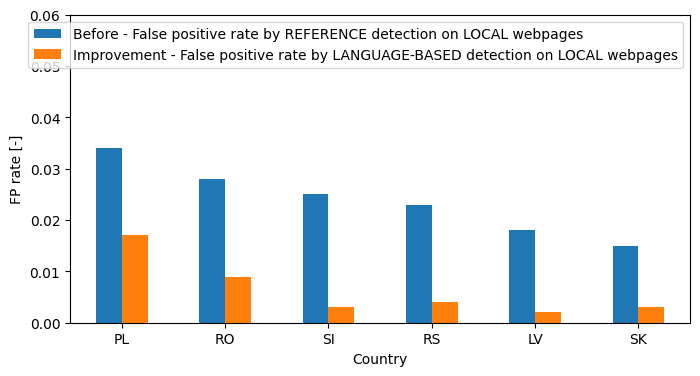

In [26]:
results_setA[['country','fp_reference','fp_language']].plot.bar(
    x='country',xlabel='Country', ylabel='FP rate [-]',figsize=(8,4),rot=0,ylim=[0,0.06])
plt.legend(['Before - False positive rate by REFERENCE detection on LOCAL webpages',
            'Improvement - False positive rate by LANGUAGE-BASED detection on LOCAL webpages'])
plt.savefig(f'result-figures/fig-fp-country-minor-setA.pdf', bbox_inches='tight',pad_inches=0)

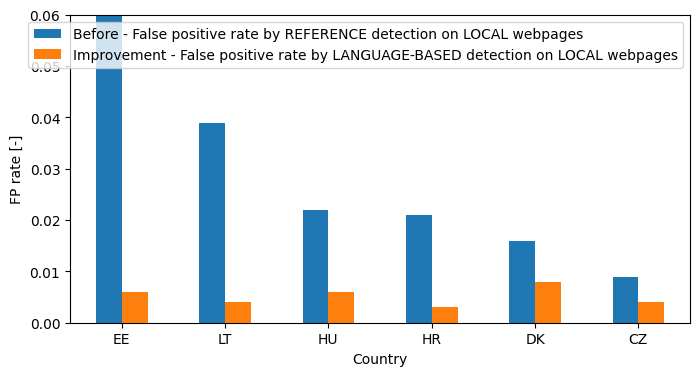

In [27]:
results_setB[['country','fp_reference','fp_language']].plot.bar(
    x='country',xlabel='Country', ylabel='FP rate [-]',figsize=(8,4),rot=0,ylim=[0,0.06])
plt.legend(['Before - False positive rate by REFERENCE detection on LOCAL webpages',
            'Improvement - False positive rate by LANGUAGE-BASED detection on LOCAL webpages'])
plt.savefig(f'result-figures/fig-fp-country-minor-setB.pdf', bbox_inches='tight',pad_inches=0)

## Statistical validation

In [28]:
for item in COUNTRY_MI:
    
    print(item)

    fpr_reference_cval = []    
    fpr_language_cval = []

    for cv in range(10):

        # local country user
        data = country_test.loc[country_test.country == item].sample(3000,random_state=cv)
       
        feature = vectorizer.transform(data.url)

        ## reference ##
    
        data['reference'] = model_reference.predict(feature)
        cm_norm = confusion_matrix(data.phishing,data.reference,normalize='true')
        fpr_reference = round(float(cm_norm.ravel()[1]),3)
        fpr_reference_cval.append(fpr_reference)

        ## language ##
        
        data['language'] = model_language.predict(feature)
        cm_norm = confusion_matrix(data.phishing,data.language,normalize='true')
        fpr_language = round(float(cm_norm.ravel()[1]),3)
        fpr_language_cval.append(fpr_language)
 
    print(fpr_reference_cval)
    print(fpr_language_cval)
    
    differences = [x - y for x, y in zip(fpr_reference_cval, fpr_language_cval)]
    stat, p_value = shapiro(differences)
    print(f'Shapiro-Wilk: {stat}, P-value: {p_value}')    
    
    stat, p_value = ttest_rel(fpr_reference_cval, fpr_language_cval)
    print(f'T-test: {stat}, P-value: {p_value}')
    print()

CZ
[0.009, 0.007, 0.007, 0.011, 0.009, 0.01, 0.012, 0.007, 0.009, 0.011]
[0.003, 0.003, 0.003, 0.005, 0.005, 0.003, 0.005, 0.003, 0.003, 0.003]
Shapiro-Wilk: 0.8525594799317795, P-value: 0.062304340032468736
T-test: 11.76235270583528, P-value: 9.128584440432631e-07

DK
[0.013, 0.012, 0.014, 0.016, 0.017, 0.016, 0.019, 0.015, 0.011, 0.012]
[0.007, 0.006, 0.009, 0.005, 0.008, 0.006, 0.009, 0.008, 0.007, 0.008]
Shapiro-Wilk: 0.9058657756455097, P-value: 0.25378274839956394
T-test: 8.702888011474109, P-value: 1.1226811173915238e-05

EE
[0.067, 0.056, 0.057, 0.064, 0.068, 0.074, 0.058, 0.063, 0.066, 0.063]
[0.006, 0.007, 0.006, 0.004, 0.007, 0.009, 0.006, 0.008, 0.005, 0.005]
Shapiro-Wilk: 0.9256387580565453, P-value: 0.4063890787892953
T-test: 34.373126062112654, P-value: 7.369137669733643e-11

HR
[0.02, 0.021, 0.019, 0.022, 0.02, 0.021, 0.02, 0.018, 0.025, 0.019]
[0.002, 0.001, 0.002, 0.003, 0.004, 0.005, 0.003, 0.002, 0.002, 0.002]
Shapiro-Wilk: 0.8281113384582518, P-value: 0.03175257316